In [1]:
import csv
from lxml import etree as et
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from random import choices, random

In [56]:
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
class MinNodeHeap:

    def __init__(self,g={}):
        self.heap = []
        self.size = 0
        self.g = g

    def left_index(self,i):
        return 2*i+1

    def right_index(self,i):
        return 2*i+2

    def parent_index(self,i):
        return (i-1)//2

    def min_heapify(self,i):
        l = self.left_index(i)
        r = self.right_index(i)

        if l < self.size and self.g[self.heap[l]]['weight'] < self.g[self.heap[i]]['weight']:
            smallest = l
        else:
            smallest = i
        if r < self.size and self.g[self.heap[r]]['weight'] < self.g[self.heap[smallest]]['weight']:
            smallest = r
        if smallest != i:
            self.g[self.heap[i]]['index'], self.g[self.heap[smallest]]['index'] = self.g[self.heap[smallest]]['index'], self.g[self.heap[i]]['index']           
            self.heap[i], self.heap[smallest] = self.heap[smallest], self.heap[i]
            self.min_heapify(smallest)

    def build_min_heap(self,_NodeView):
        self.heap = [None for i in range(len(_NodeView))]
        for elem in self.g.keys():
            self.heap[self.g[elem]['index']] = elem
#         self.heap = list(_NodeView)
        self.size = len(_NodeView)
#         for i in range(len(_NodeView)//2,-1,-1):
#             self.min_heapify(i)
            
    def extract_min(self):
        if self.size < 1:
            return None
        _min = self.heap[0]
        self.g[self.heap[self.size-1]]['index'] = self.g[self.heap[0]]['index']
        self.heap[0] = self.heap[self.size-1]      
        self.size -= 1
        self.min_heapify(0)
        return _min
    
    def decrease_key(self,_id,key):
        i = self.g[_id]['index']
        if key > self.g[_id]['weight']:
            raise KeyError
        self.g[_id]['weight'] = key
        while (i > 0) and (self.g[self.heap[self.parent_index(i)]]['weight'] > self.g[self.heap[i]]['weight']):
            self.g[self.heap[self.parent_index(i)]]['index'], self.g[self.heap[i]]['index'] = self.g[self.heap[i]]['index'], self.g[self.heap[self.parent_index(i)]]['index']
            self.heap[self.parent_index(i)], self.heap[i] = self.heap[i], self.heap[self.parent_index(i)]
            i = self.parent_index(i)

            
def initialize_single_sourse(G,_from):
    g = {}
    nodes_list = list(G.nodes).copy()
    nodes_list.remove(_from)
    for v_id, i in zip(nodes_list,range(1,len(G.nodes))):
        g[v_id] = {'way': [], 'weight':float('inf'), 'index':i}
    g[_from] = {'way':[_from], 'weight':0, 'index':0}
    return g

def relax(G,min_heap,_from,_to):
    if min_heap.g[_to]['weight'] > min_heap.g[_from]['weight'] + G[_from][_to]['weight']:
        key = min_heap.g[_from]['weight'] + G[_from][_to]['weight']
        min_heap.decrease_key(_to,key)
        min_heap.g[_to]['way'] = (min_heap.g[_from]['way']).copy()
        min_heap.g[_to]['way'].append(_to)
        
def dijkstra(G,_from,to_list = 'empty'):
    if to_list == 'empty':
        to_list = list(G.nodes)
    g = initialize_single_sourse(G,_from)
    finish = 0
    nodes = MinNodeHeap(g)
    nodes.build_min_heap(G.nodes)
    while nodes.size > 0 and finish < len(to_list):
        u = nodes.extract_min()
        if to_list.count(u) > 0:
            finish += 1
        for v in G.successors(u):
            relax(G,nodes,u,v)
    return g


In [3]:
def readAdjMatrix(path_doc):
    with open(path_doc,'r') as f:
        G = nx.DiGraph()
        lines = f.readlines()
        nlist = lines[0][1:-1].split(',')
        G.add_nodes_from(nlist)
        lines = lines[1:]
        elist,a,l = [],True,len(nlist)
        a *= (l == len(lines))
        for i in range(len(lines)):
            split_line = lines[i].split(',')
            _from, weights = split_line[0], list(map(int,split_line[1:]))
            a *= (l == len(weights))
            for j in range(len(weights)):
                if weights[j] != 0:
                    elist.append((_from,nlist[j],{'weight': weights[j]}))
        G.add_edges_from(elist)
        print('ok' if a == 1 else 'This is not nice.')
        return G


In [4]:
def write_dijkstra_csv(G,filename,from_list,to_list):
    with open(filename,'w',newline='') as f:
        f.write('from,to,way_weight,way\n')
        for _from in from_list:
            a = dijkstra(G,_from,to_list)
            for _to in to_list:
                s = _from + ',' + _to + ',' + str(a[_to]['weight'])
                if a[_to]['way'] != '':
                    way = ','.join(a[_to]['way'])
                    s = s + ',' + way
                f.write(s + '\n')

def read_dijkstra_csv(filename):
    min_ways = {}         
    with open(filename,'r') as f:
        lines = f.readlines()
        lines = lines[1:] 
        for line in lines:
            split_line = line[:-1].split(',')
            _from = split_line[0]
            _to = split_line[1]
            weight = float(split_line[2]) 
            way = split_line[3:]
            if min_ways.get(_from) == None:
                min_ways[_from] = {_to:{'weight':weight,'way':way}}
            else:
                min_ways[_from][_to] = {'weight':weight,'way':way}
    return min_ways
            


In [5]:
def write_ways(filename,min_way):
    with open(filename,'w',newline='') as f:  
        f.write('from_id,to_id,way_weight\n')
        s = ''
        for _from in min_way.keys():
            s = s + _from + ',' + min_way[_from]['to'] + ',' + str(min_way[_from]['weight'])+'\n'
        f.write(s)


In [6]:
def search_min_oneways(min_ways,from_list,to_list):
    min_way = {}
    for _from in from_list:
        for _to in to_list:
            if _from != _to:
                if min_way.get(_from) == None:
                    min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'],'way':min_ways[_from][_to]['way']}
                elif min_way[_from]['weight'] > min_ways[_from][_to]['weight']:
                    min_way[_from]['to'] = _to
                    min_way[_from]['weight'] = min_ways[_from][_to]['weight']
                    min_way[_from]['way'] =  min_ways[_from][_to]['way']
    return min_way


In [7]:
def search_min_ways_there_and_back(min_ways,from_list,to_list):
    min_way = {}
    for _from in from_list:
        for _to in to_list:
            if _from != _to:
                if min_way.get(_from) == None:
                    min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight'],'way':min_ways[_from][_to]['way'],'way_back':min_ways[_to][_from]['way']}
                elif min_way[_from]['weight'] > min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']:
                    min_way[_from]['to'] = _to
                    min_way[_from]['weight'] = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                    min_way[_from]['way'] =  min_ways[_from][_to]['way']
                    min_way[_from]['way_back'] = min_ways[_to][_from]['way']
    return min_way


In [33]:
def search_near_ways(min_ways,max_weight,from_list,to_list):
    near_ways = []
    for _from in from_list:
        for _to in to_list:      
            if min_ways[_from][_to]['weight'] <= max_weight and _from != _to:
                near_ways.append([_from,_to,min_ways[_from][_to]['weight'],min_ways[_from][_to]['way']])
    return near_ways
                

In [34]:
def search_near_ways_there_and_back(min_ways,max_weight,from_list,to_list):
    near_ways = []
    for _from in from_list:
        for _to in to_list:
            weight = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
            if weight <= max_weight and _from != _to:
                near_ways.append([_from, _to, weight, min_ways[_from][_to]['way'], min_ways[_to][_from]['way']])
    return near_ways


In [10]:
def search_minmax_way(min_ways,from_list,to_list):
    obj = 'start'
    minmax_way = {obj:{'weight':float('inf')}}
    for _from in from_list:
        weight = 0
        for _to in to_list:
            if min_ways[_from][_to]['weight'] > weight:
                to = _to
                weight = min_ways[_from][_to]['weight']
        if weight < minmax_way[obj]['weight']:
            minmax_way = {_from:{'to':to,'weight':weight}}
            obj = _from    
    minmax_way[obj]['way'] = min_ways[obj][minmax_way[obj]['to']]['way'].copy()
    
    return minmax_way


In [11]:
def search_minmax_way_there_and_back(min_ways,from_list,to_list):
    obj = 'start'
    minmax_way = {obj:{'weight':float('inf')}}
    for _from in from_list:
        weight = 0
        for _to in to_list:
            w0 = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
            if w0 != float('inf') and w0 > weight:
                to = _to
                weight = w0
        if weight < minmax_way[obj]['weight']:             
            minmax_way = {_from:{'to':to,'weight':weight}}
            obj = _from            
    minmax_way[obj]['way'] = min_ways[obj][minmax_way[obj]['to']]['way'].copy() + min_ways[minmax_way[obj]['to']][obj]['way'].copy()
    
    return minmax_way


In [51]:
def search_min_distance_to_node(min_ways,from_list,to_list):
    #Для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна
    min_sum = float('inf')
    ways = []
    for _from in from_list:
        _sum = 0
        for _to in to_list:       
            _sum += min_ways[_from][_to]['weight']
        if _sum < min_sum:
            min_sum = _sum
            obj = _from
            for _to in to_list:
                if obj!= _to:
                    ways.append([obj,_to, min_ways[obj][_to]['weight'], min_ways[obj][_to]['way']])

    return obj,min_sum,ways

In [52]:
def search_min_weight_to_node(min_ways,from_list,to_list):
    #Для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.
    min_sum = float('inf')
    ways = []
    for _from in from_list:
        _sum = 0
        edges_set = set()
        for _to in to_list:
            edges_set.add(_from + ' ' + _to)
        for elem in list(edges_set):
            i,j = elem.split(' ')
            _sum += min_ways[i][j]['weight']
        if _sum < min_sum:
            min_sum = _sum
            obj = _from
            for _to in to_list:
                if obj!= _to:
                    ways.append([obj,_to, min_ways[obj][_to]['weight'], min_ways[obj][_to]['way']])
    
    return obj,min_sum,ways


In [14]:
#G.add_node(a)
#G.add_edge(from, to, weight=w0)
#G.add_nodes_from(nlist)
#elist = [('a', 'b', 5.0), ('b', 'c', 3.0)]
#G.add_edges_from(elist)
#G.remove_node(a)
#G.remove_nodes_from(nlist)
#G.remove_edge(from, to)
#G.remove_edges_from(elist)
#G[from][to]['weight'] = w1


In [15]:
G = readAdjMatrix('example.csv')
from_list, to_list = list(G.nodes),list(G.nodes)
dijkstra_file = 'dijkstra.txt'
min_oneway_file1,min_oneway_file2 = 'min_oneway1.txt','min_oneway2.txt'
mwtb_file = 'min_way_there_and_back.txt'
near_ways_file1,near_ways_file2 = 'near_way1.txt','near_way1.txt'
nwtb_file = 'near_way_there_and_back.txt'


ok


In [53]:
write_dijkstra_csv(G,dijkstra_file,from_list,to_list)
max_weight = 1
#Если нужно без записи
#res = []
#for _from in from_list:
#    res.append(dijkstra(G,_from,to_list))
min_ways = read_dijkstra_csv(dijkstra_file)

#1a
min_oneways1 = search_min_oneways(min_ways,from_list,to_list)
min_oneways2 = search_min_oneways(min_ways,to_list,from_list)
min_ways_there_and_back = search_min_ways_there_and_back(min_ways,from_list,to_list)

#1b
near_ways1 = search_near_ways(min_ways,max_weight,from_list,to_list)
near_ways2 = search_near_ways(min_ways,max_weight,from_list,to_list)
near_ways_there_and_back = search_near_ways_there_and_back(min_ways,max_weight,from_list,to_list)

#2
minmax_way1 = search_minmax_way(min_ways,from_list,to_list)
minmax_way2 = search_minmax_way(min_ways,from_list,to_list)
minmax_way_there_and_back = search_minmax_way_there_and_back(min_ways,from_list,to_list)

#3
min_distance_to_node,min_distance,min_distance_way = search_min_distance_to_node(min_ways,from_list,to_list)
#4
min_weight_to_node,min_weight,min_weight_way = search_min_weight_to_node(min_ways,from_list,to_list)


In [17]:
def draw_ways(G,ways):
    if type(ways) == dict:
        ways = [list(ways.values())[i]['way'] for i in range(len(ways.keys()))]
    elif type(ways) == list:
        ways = [ways[i][3] for i in range(len(ways))]
    edgelist = []
    for way in ways:
        for edge in zip(way[:-1],way[1:]):
            edgelist.append(edge)
    nx.draw_networkx(G, with_labels=True, arrowsize = 2, node_size = 75, font_size = 3, edgelist = edgelist, edge_color = 'r')

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


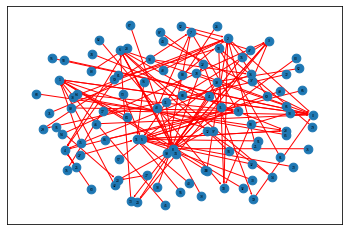

In [49]:
min_ways_list = list(min_oneways1.values())
print([min_ways_list[i]['weight'] for i in range(len(min_ways_list))])
draw_ways(G,min_oneways1)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


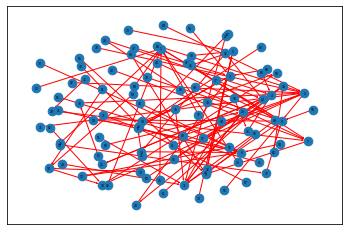

In [50]:
min_ways_list = list(min_oneways2.values())
print([min_ways_list[i]['weight'] for i in range(len(min_ways_list))])
draw_ways(G,min_oneways2)

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]


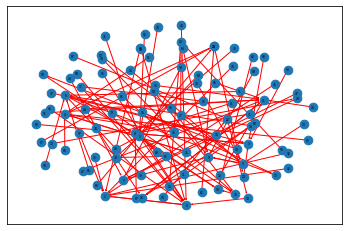

In [48]:
min_ways_list = list(min_ways_there_and_back.values())
print([min_ways_list[i]['weight'] for i in range(len(min_ways_list))])
draw_ways(G,min_ways_there_and_back)

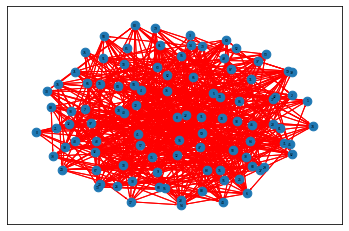

In [36]:
draw_ways(G,near_ways1)

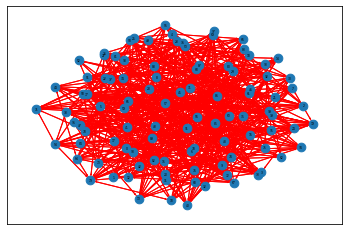

In [37]:
draw_ways(G,near_ways2)

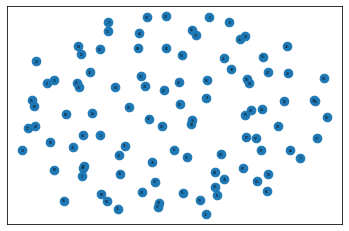

In [38]:
draw_ways(G,near_ways_there_and_back)

{'0': {'to': '4', 'weight': 3.0, 'way': ['0', '46', '4']}}


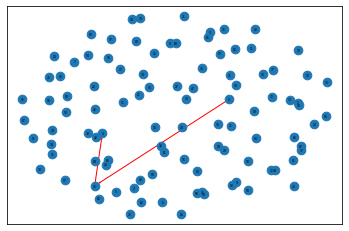

In [24]:
print(minmax_way1)
draw_ways(G,minmax_way1)

{'0': {'to': '4', 'weight': 3.0, 'way': ['0', '46', '4']}}


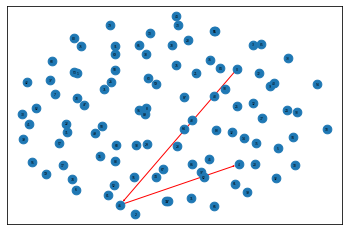

In [25]:
print(minmax_way2)
draw_ways(G,minmax_way2)

{'0': {'to': '4', 'weight': 6.0, 'way': ['0', '46', '4', '4', '25', '70', '0']}}


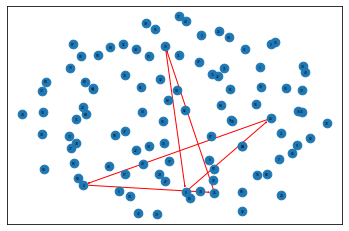

In [26]:
print(minmax_way_there_and_back)
draw_ways(G,minmax_way_there_and_back)

92 191.0


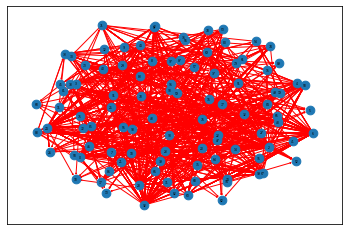

In [54]:
print(min_distance_to_node,min_distance)
draw_ways(G,min_distance_way)

92 191.0


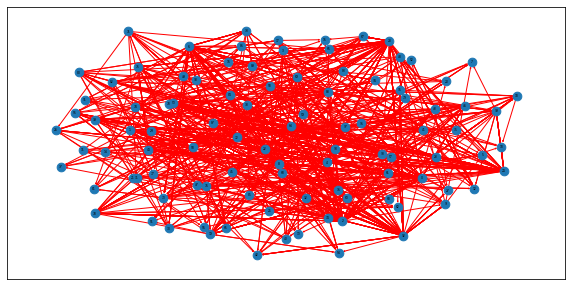

In [57]:
print(min_weight_to_node,min_weight)
draw_ways(G,min_weight_way)

In [ ]:
write_ways(min_oneway_file1,min_oneway1)
write_ways(min_oneway_file2,min_oneway2)
write_ways(mwtb_file,min_way_there_and_back)
write_ways(near_ways_file1,near_ways1)
write_ways(near_ways_file2,near_ways2)
write_ways(nwtb_file,near_way_there_and_back)
